# **Lithology Boundary Definition using CWT**

<img src="https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/test_on_synthetic_data.JPG" alt="Your image title" width="500"/>

Based on "***Improving Automated Geological Logging of Drill Holes by Incorporating Multiscale Spatial Methods***" works by [Evelyn Jun Hill](https://www.researchgate.net/publication/339871641_Improving_Automated_Geological_Logging_of_Drill_Holes_by_Incorporating_Multiscale_Spatial_Methods). 

Github : https://github.com/galena100/Transform2020

**1. What you guys do?**
---




Estimate the lithology boundaries from downhole geophysics log, using a continuous wavelet transform (CWT).

**2. Who are you guys?**
---

- **Jared Armstrong** :
 
  "*I love working at the intersection of mining coal geology and Database Technology.  Free your data to dissolve your difficulties*"

  E-mail : jared@wholesolutions.com.au

  Slack : @Jared 

- **Leo C. Dinendra** : 

  "*A geophysicist DM worker in an oil company. I love for-loops and will fight for it.*"

  E-mail : leocd91@gmail.com , [LinkedIn](https://www.linkedin.com/in/leo-c-0988727b/)

  Slack : @leo 

- **Martin Bentley** :

  "*Generally interested in rocks and computers. Accidental geophysicist.*"

  E-mail : mtb@martinb.za.net

  Slack : @mtb-za


**3. How you guys do it?**
---

### Data Loading and Conditioning

In [1]:
!pip install pywavelets

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt

In [3]:
!wget "https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/test001_gamma.csv"

--2020-06-14 04:10:00--  https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/test001_gamma.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615682 (601K) [text/plain]
Saving to: ‘test001_gamma.csv’

test001_gamma.csv   100%[===================>] 601.25K  --.-KB/s    in 0.05s   

2020-06-14 04:10:01 (12.7 MB/s) - ‘test001_gamma.csv’ saved [615682/615682]



In [4]:
!wget "https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/test001_litho_code.csv"

--2020-06-14 04:10:03--  https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/test001_litho_code.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924 (3.8K) [text/plain]
Saving to: ‘test001_litho_code.csv’

test001_litho_code. 100%[===================>]   3.83K  --.-KB/s    in 0s      

2020-06-14 04:10:03 (67.0 MB/s) - ‘test001_litho_code.csv’ saved [3924/3924]



In [5]:
!wget "https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/Lithology_Lookup_Table.csv"

--2020-06-14 04:10:06--  https://raw.githubusercontent.com/galena100/Transform2020/master/t20-litho_boundary_from_gamma/Lithology_Lookup_Table.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196 [text/plain]
Saving to: ‘Lithology_Lookup_Table.csv’

Lithology_Lookup_Ta 100%[===================>]     196  --.-KB/s    in 0s      

2020-06-14 04:10:06 (10.5 MB/s) - ‘Lithology_Lookup_Table.csv’ saved [196/196]



In [0]:
dataraw=np.loadtxt('test001_gamma.csv',skiprows=1,delimiter=',')  #loading csv
dataraw[:,0]=dataraw[:,0]*-1.0                                    #make the depth positive
data=dataraw[np.arange(0,36595,10),:]                             #resampling data
dt=data[1,0]-data[0,0]                                            #calculate sampling rate
dep=data[:,0]                                                     #getting the depth
curve=savgol_filter(data[:,1], 21, 3)                             #getting the GR data and filter using savgol
fscales = np.arange(1, 100,1)                                     #length of cwt result (resolution)

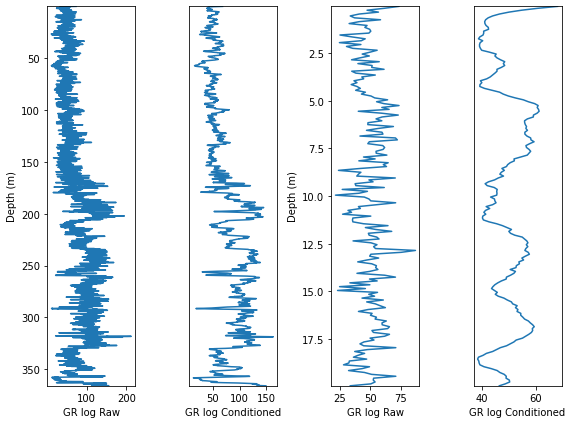

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(8, 6))
#fig.suptitle('Data Conditioning', fontsize=15)
ax1.plot(data[:,1],dep)
ax1.set_ylim([np.min(dep),np.max(dep)])
ax1.invert_yaxis()
ax1.set_xlabel('GR log Raw')
ax1.set_ylabel('Depth (m)')

ax2.plot(curve,dep)
ax2.set_ylim([np.min(dep),np.max(dep)])
ax2.invert_yaxis()
ax2.set_xlabel('GR log Conditioned')
ax2.set_ylabel('Depth (m)')
ax2.yaxis.set_visible(False)

maxdep=20

ax3.plot(data[0:int(maxdep/dt),1],dep[0:int(maxdep/dt)])
ax3.set_ylim([np.min(dep),dep[int(maxdep/dt)-1]])
ax3.invert_yaxis()
ax3.set_xlabel('GR log Raw')
ax3.set_ylabel('Depth (m)')

ax4.plot(curve[0:int(maxdep/dt)],dep[0:int(maxdep/dt)])
ax4.set_ylim([np.min(dep),dep[int(maxdep/dt)-1]])
ax4.invert_yaxis()
ax4.set_xlabel('GR log Conditioned')
ax4.set_ylabel('Depth (m)')
ax4.yaxis.set_visible(False)
fig.tight_layout()

### CWT, Boundary Definition, and Boundary Strength Computation

In [0]:
wavelet = 'gaus2'
[cfs, frequencies] = pywt.cwt(curve, fscales, wavelet, dt)
zcwt=cfs.T

In [0]:
wavelet2 = 'gaus1'
[cfs, frequencies] = pywt.cwt(curve, fscales, wavelet2, dt)
zcwt2=cfs.T

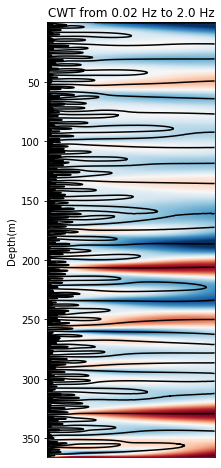

In [10]:
fig, (ax2) = plt.subplots(1,1,figsize=(3, 8))
cs=ax2.contour(fscales,dep,zcwt,levels=[0.0], colors='k',extend='both')
ax2.set_title('CWT from '+str(np.round(np.min(frequencies),2))+' Hz to '+str(np.round(np.max(frequencies),2))+' Hz')
ax2.invert_yaxis()
ax2.contourf(fscales,dep,zcwt2,levels=np.arange(np.min(zcwt),np.max(zcwt),1), 
              cmap="RdBu_r", extend='both')
ax2.set_ylabel('Depth(m)')
ax2.xaxis.set_visible(False)

In [0]:
#boundary
#get 0 level
thres=0.1 #percent from std threshold
x0=np.array([])
y0=np.array([])
i0=np.array([])
id0=0
ncdat=np.zeros([len(cs.allsegs[0])])
for i in range(0,len(cs.allsegs[0])):
    ncdat[i]=len(cs.allsegs[0][i])

for i in range(0,len(cs.allsegs[0])):
    if len(cs.allsegs[0][i])>(np.std(ncdat)*thres):
        dat0= cs.allsegs[0][i]
        y0 = np.hstack((y0, dat0[:,0]))
        x0 = np.hstack((x0, dat0[:,1]))
        i0 = np.hstack((i0, np.ones([len(dat0[:,1])])*id0))
        id0=id0+1

#rescale to a array position scale (to call the zcwt2)
x0=x0-np.min(dep)
x02=x0/dt
y02=(y0-np.min(y0))/(np.max(y0)-np.min(y0))*(len(fscales)-1)

z0=np.zeros([x0.shape[0]],dtype=float)

for i in range(z0.shape[0]):
    z0[i]=zcwt2[int(np.floor(x02[i])),int(np.floor(y02[i]))]

#getting the boundary
bo=np.array([])
for i in range(0,id0):
    locmax=np.where(z0 == np.max(z0[i0==i]))[0][0]
    locmin=np.where(z0 == np.min(z0[i0==i]))[0][0]
    if z0[locmax]>0.0:
        if i==0 and bo.shape[0]==0:
            bo=np.hstack((bo, [x02[locmax],y02[locmax],z0[locmax]]))
        else:
            bo=np.vstack((bo, [x02[locmax],y02[locmax],z0[locmax]]))
    if z0[locmin]<0.0:
        if i==0 and bo.shape[0]==0:
            bo=np.hstack((bo, [x02[locmin],y02[locmin],z0[locmin]]))
        else:
            bo=np.vstack((bo, [x02[locmin],y02[locmin],z0[locmin]]))      

bo=bo[bo[:,0].argsort()]

ax2.plot((bo[:,1]/fscales.shape[0])*(np.max(fscales)-np.min(fscales))+np.min(fscales),(bo[:,0])*dt+np.min(dep),'wo',markersize=5,markeredgecolor='y')        
ax2.yaxis.set_visible(False)

#calculate the boundary strength & getting the signal polarity
bos=np.zeros([len(dep),2],dtype=float)
for i in range(0,bo.shape[0]):
    bos[int(np.round(bo[i,0])),0]=np.abs(bo[i,2])/np.max(np.abs(bo[:,2]))
    bos[int(np.round(bo[i,0])),1]=np.sign(curve[int(np.round(bo[i,0]))])

datas=bos

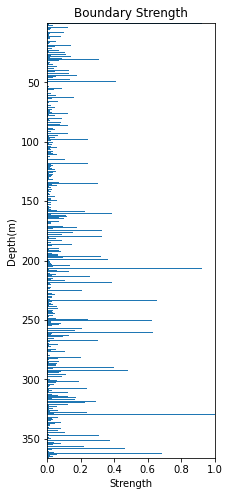

In [12]:
fig, (ax3) = plt.subplots(1,1,figsize=(3, 8))
ax3.set_title('Boundary Strength')
ax3.barh(dep,bos[:,0])
ax3.set_ylim([np.min(dep),np.max(dep)])
ax3.set_xlim([0.0,1.0])
ax3.invert_yaxis()
ax3.set_ylabel('Depth(m)')
ax3.set_xlabel('Strength')
ax3.set_aspect('auto')

### Mosaic Plot

In [0]:
mosaic=np.zeros([datas.shape[0],100],dtype=int)*np.nan

colnum=1000 #color range(?)
colrange=np.linspace(0,colnum,datas.shape[0],dtype=int)

for i in range(0,datas.shape[0]):
    if datas[i,0] != 0.0:
        mosaic[i,0:int(np.floor(datas[i,0]*100.0))]=colrange[i]
for i in range(0,datas.shape[0]):
    if ~np.isnan(mosaic[i,0]):
        for j in range(0,100):
            if np.isnan(mosaic[i,j]):
                fl=i
                while True:
                    if fl<0:
                      break
                    mosaic[fl,j-1]=mosaic[i,0]
                    fl=fl-1
                    if fl<0 or ~np.isnan(mosaic[fl,j-1]):
                        break
                break
for i in range(0,datas.shape[0]):
    if ~np.isnan(mosaic[i,0]):
        for j in range(0,100):
            if np.isnan(mosaic[i,j]):
                fl=i+1
                while True:
                    if fl>datas.shape[0]-1:
                      break
                    mosaic[fl,j-1]=mosaic[i,0]+2
                    fl=fl+1
                    if fl>datas.shape[0]-1 or ~np.isnan(mosaic[fl,j-1]):
                        break
                break
mosaic[0:np.where(datas[:,0]==1.0)[0][0],99]=100.0
mosaic[np.where(datas[:,0]==1.0)[0][0]:,99]=mosaic[np.where(datas[:,0]==1.0)[0][0],0]
mosaic2=mosaic
pdmos=pd.DataFrame(mosaic)
pdmos=pdmos.T
pdmos=pdmos.fillna(method='bfill').T
mosaic=pdmos.values
res_grid=1
mosaic3=mosaic[np.arange(0,datas.shape[0],res_grid),:]
#mosaic3=mosaic
x=np.where(~np.isnan(mosaic2))[0][:]
x=np.floor(x/res_grid).astype(int)
#x=np.floor(x).astype(int)
y=np.where(~np.isnan(mosaic2))[1][:]
grids=np.zeros([mosaic3.shape[0],100])*np.nan
grids[x,y]=1.0  

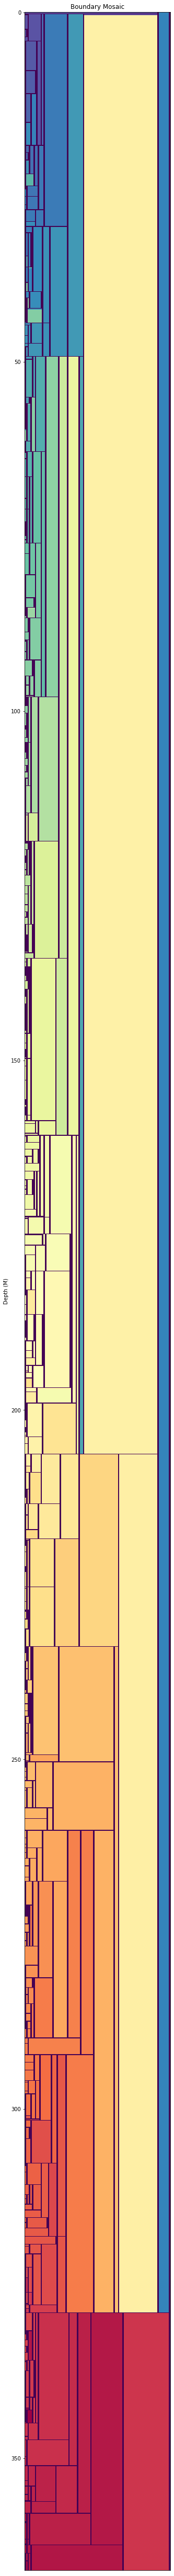

In [14]:
real_x=np.array([0,mosaic.shape[1]])
real_y=np.linspace(0,mosaic.shape[0]*dt,mosaic.shape[0])
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[-1]+dy,real_y[0]-dy]

fig, (ax3) = plt.subplots(1,1,figsize=(5, 90))
ax3.set_title('Boundary Mosaic')
ax3.imshow(mosaic,extent=extent,interpolation='none',cmap='Spectral_r')
ax3.imshow(grids,extent=extent,interpolation='none')
ax3.set_aspect('auto')
ax3.set_ylabel('Depth (M)')
ax3.xaxis.set_visible(False)

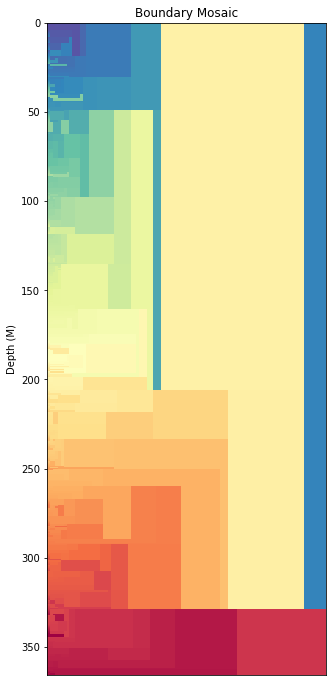

In [15]:
real_x=np.array([0,mosaic.shape[1]])
real_y=np.linspace(0,mosaic.shape[0]*dt,mosaic.shape[0])
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[-1]+dy,real_y[0]-dy]

fig, (ax3) = plt.subplots(1,1,figsize=(5, 12))
ax3.set_title('Boundary Mosaic')
ax3.imshow(mosaic,extent=extent,interpolation='none',cmap='Spectral_r')
#ax3.imshow(grids,interpolation='none')
ax3.set_aspect('auto')
ax3.set_ylabel('Depth (M)')
ax3.xaxis.set_visible(False)

In [0]:
lith=np.loadtxt('test001_litho_code.csv',skiprows=1,delimiter=',',dtype=str)
litid=np.loadtxt('Lithology_Lookup_Table.csv',skiprows=1,delimiter=',',dtype=str)
litdata=np.zeros([dep.shape[0],2],dtype=int)
litlookup=pd.DataFrame(data=np.arange(0,litid.shape[0],1))
litlookup=litlookup.T
litlookup.columns=litid[:,0]
for i in range(0,dep.shape[0]):
    for j in range(0,lith.shape[0]):
        if dep[i]<float(lith[j,1]) and dep[i]>=float(lith[j,0]):
            litdata[i,:]=litlookup[lith[j,2]][0]
            break

Text(0.5, 0, 'Lithology')

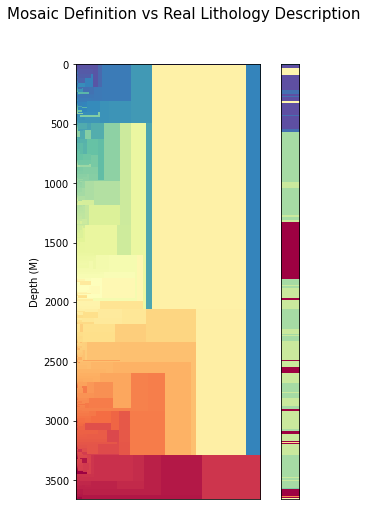

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 8),gridspec_kw={'width_ratios': [5, 0.5]})
fig.suptitle('Mosaic Definition vs Real Lithology Description', fontsize=15)
ax1.imshow(mosaic3,interpolation='none',cmap='Spectral_r')
#ax1.imshow(grids,interpolation='none')
ax1.set_aspect('auto')
ax1.set_ylabel('Depth (M)')
ax1.xaxis.set_visible(False)

litdata[litdata==3]=17

ax2.imshow(litdata,interpolation='none',cmap='Spectral_r')
ax2.set_aspect('auto')

ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_xlabel('Lithology')

Text(0.5, 0, 'Lithology')

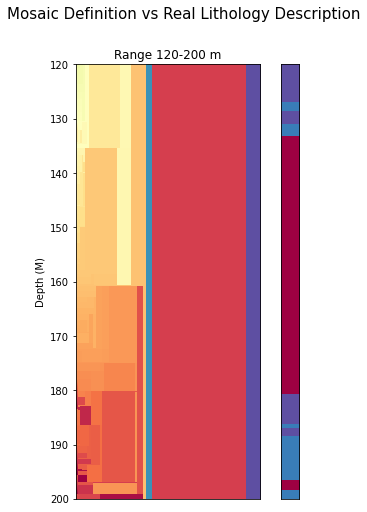

In [25]:
depmin=120
depmax=200

dmin=int(depmin/dt)
dmax=int(depmax/dt)

real_x=np.array([0,mosaic3.shape[1]])
real_y=np.linspace(depmin,depmax,len(mosaic3[dmin:dmax,:]))
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[-1]+dy,real_y[0]-dy]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 8),gridspec_kw={'width_ratios': [5, 0.5]})
fig.suptitle('Mosaic Definition vs Real Lithology Description', fontsize=15)
ax1.set_title('Range '+str(depmin)+'-'+str(depmax)+' m')
ax1.imshow(mosaic[int(depmin/dt):int(depmax/dt),:],extent=extent,interpolation='none',cmap='Spectral_r')
#ax1.imshow(grids[int(depmin):int(depmax),:],interpolation='none')
ax1.set_aspect('auto')
ax1.set_ylabel('Depth (M)')
ax1.xaxis.set_visible(False)

litdata[litdata==3]=17

ax2.imshow(litdata[dmin:dmax,:],interpolation='none',cmap='Spectral_r')
ax2.set_aspect('auto')

ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_xlabel('Lithology')

Text(0.5, 0, 'Lithology')

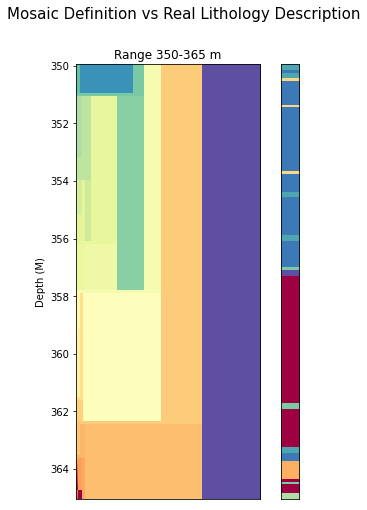

In [31]:
depmin=350
depmax=365

dmin=int(depmin/dt)
dmax=int(depmax/dt)

real_x=np.array([0,mosaic3.shape[1]])
real_y=np.linspace(depmin,depmax,len(mosaic3[dmin:dmax,:]))
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[-1]+dy,real_y[0]-dy]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 8),gridspec_kw={'width_ratios': [5, 0.5]})
fig.suptitle('Mosaic Definition vs Real Lithology Description', fontsize=15)
ax1.set_title('Range '+str(depmin)+'-'+str(depmax)+' m')
ax1.imshow(mosaic[int(depmin/dt):int(depmax/dt),:],extent=extent,interpolation='none',cmap='Spectral_r')
#ax1.imshow(grids[int(depmin/dt):int(depmax/dt),:],interpolation='none')
ax1.set_aspect('auto')
ax1.set_ylabel('Depth (M)')
ax1.xaxis.set_visible(False)

litdata[litdata==3]=17

ax2.imshow(litdata[dmin:dmax,:],interpolation='none',cmap='Spectral_r')
ax2.set_aspect('auto')

ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_xlabel('Lithology')

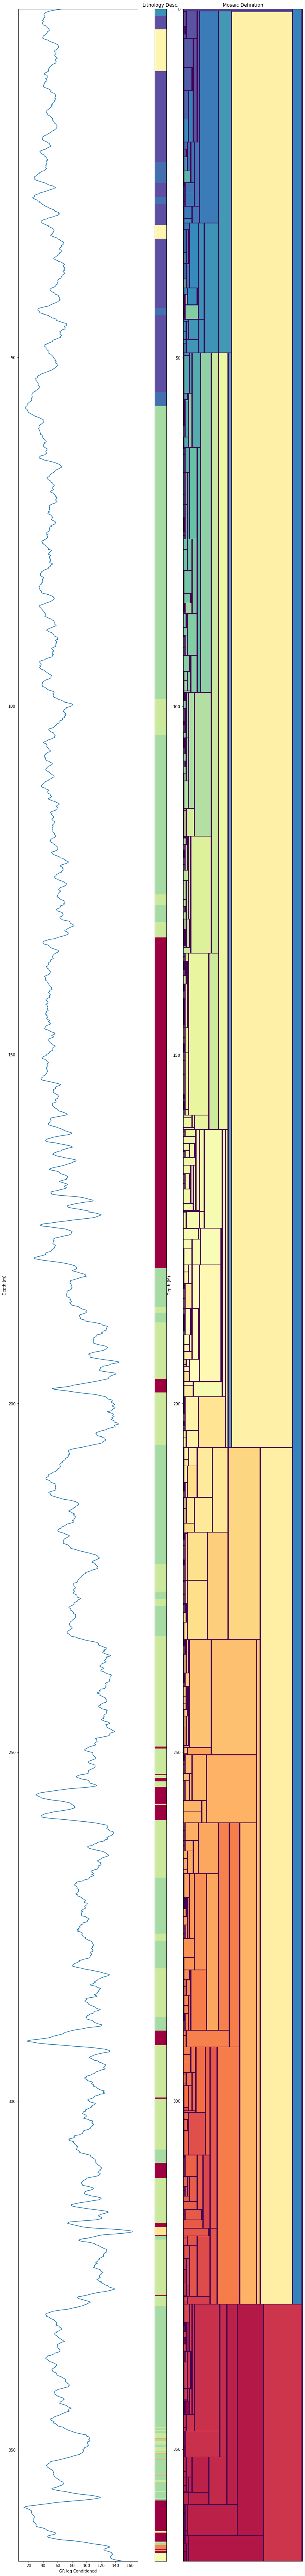

In [27]:
real_x=np.array([0,mosaic.shape[1]])
real_y=np.linspace(0,mosaic.shape[0]*dt,mosaic.shape[0])
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[-1]+dy,real_y[0]-dy]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13, 120),gridspec_kw={'width_ratios': [5, 0.5, 5]})


litdata[litdata==3]=17


ax1.plot(curve,dep)
ax1.set_ylim([np.min(dep),np.max(dep)])
ax1.invert_yaxis()
ax1.set_xlabel('GR log Conditioned')
ax1.set_ylabel('Depth (m)')
#ax1.yaxis.set_visible(False)

ax2.set_title('Lithology Desc.')
ax2.imshow(litdata,interpolation='none',cmap='Spectral_r')
ax2.set_aspect('auto')
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_xlabel('Lithology')

ax3.set_title('Mosaic Definition')
ax3.imshow(mosaic3,extent=extent,interpolation='none',cmap='Spectral_r')
ax3.imshow(grids,extent=extent,interpolation='none')
ax3.set_aspect('auto')
ax3.set_ylabel('Depth (M)')
ax3.xaxis.set_visible(False)

### Put it info a Function

In [0]:
def gr_bound(dep,curve,fscales,thres):
    #    visit : https://github.com/galena100/Transform2020/
    #    Parameters
    #    ----------
    #    dep : array_like, shape (N,)
    #        the 1d array value of depth, equally spaced, because dt will be 
    #        calculated from here
    #    curve : array_like, shape (N,)
    #        the 1d array value of GR curve
    #    fscales : array_like, shape (N,)
    #        the 1d array scale of frequency resolution (not the range frequency)
    #    thres : float
    #        threshold minimum contour samples that makes a contour eligible for boundary
    #        strength calculation. Its thres x standart deviation of number sample per contour
    #    Returns
    #    ----------        
    #    bos : ndarray, shape (N,2)
    #        2D array consist of boundary strength and signal sign
    #        
    #    Examples on Syntethic Log
    #    --------
    #    import numpy as np
    #    dep=np.arange(0,350,dt)
    #    freq1=0.05
    #    freq2=0.03
    #    freq3=0.01
    #    sin1 = np.array(np.sin(dep[0:1000] * freq1 * 2.0 * np.pi)).clip(-0.5,0.5)
    #    sin2 = np.array(np.sin(dep[1000:2000] * freq2 * 2.0 * np.pi)).clip(-0.5,0.5)
    #    sin3 = np.array(np.sin(dep[2000:] * freq3 * 2.0 * np.pi)).clip(-0.5,0.5)
    #    syntwave=np.hstack((sin1,sin2,sin3))
    #    fscales = np.linspace(50,600,100)
    #    thres = 0.5
    #    [bo,bos]=gr_bound(dep,syntwave,fscales,thres)    
        
    #getting the cwt gauss1 and gauss2
    import pywt
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    wavelet = 'gaus2'
    
    dt=dep[1]-dep[0]
    [cfs, frequencies] = pywt.cwt(curve, fscales, wavelet, dt)
    #power = (abs(cfs)) ** 2
    zcwt=cfs.T
    #period = 1. / frequencies
    
    #lev_contour=np.arange(np.min(zcwt),np.max(zcwt),7)
    
    
    wavelet2 = 'gaus1'
    
    [cfs, frequencies] = pywt.cwt(curve, fscales, wavelet2, dt)
    #power = (abs(cfs)) ** 2
    zcwt2=cfs.T
    #period = 1. / frequencies
    
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(8, 6))
    ax1.plot(curve,dep)
    ax1.set_ylim([np.min(dep),np.max(dep)])
    ax1.invert_yaxis()
    cs=ax2.contour(fscales,dep,zcwt,levels=[0.0], colors='k',extend='both')
           
    ax2.invert_yaxis()
    ax2.contourf(fscales,dep,zcwt2,levels=np.arange(np.min(zcwt),np.max(zcwt),1), 
                 cmap="RdBu_r", extend='both')
    
    
    #boundary
    #get 0 level
    thres=0.8 #percent from std threshold
    x0=np.array([])
    y0=np.array([])
    i0=np.array([])
    id0=0
    ncdat=np.zeros([len(cs.allsegs[0])])
    for i in range(0,len(cs.allsegs[0])):
        ncdat[i]=len(cs.allsegs[0][i])
    
    for i in range(0,len(cs.allsegs[0])):
        if len(cs.allsegs[0][i])>(np.std(ncdat)*thres):
            dat0= cs.allsegs[0][i]
            y0 = np.hstack((y0, dat0[:,0]))
            x0 = np.hstack((x0, dat0[:,1]))
            i0 = np.hstack((i0, np.ones([len(dat0[:,1])])*id0))
            id0=id0+1
    x0=x0-np.min(dep)
    #x0[x0<0]=x0[x0<0]*-1.0
    #rescale to a array position scale (to call the zcwt2)
    x02=x0/dt
    y02=(y0-np.min(y0))/(np.max(y0)-np.min(y0))*(len(fscales)-1)
    
    z0=np.zeros([x0.shape[0]],dtype=float)
    
    for i in range(z0.shape[0]):
       # if int(np.floor(x02[i])) < (zcwt2.shape[0]):
        z0[i]=zcwt2[int(np.floor(x02[i])),int(np.floor(y02[i]))]
    
    #getting the boundary
    bo=np.array([])
    for i in range(0,id0):
        locmax=np.where(z0 == np.max(z0[i0==i]))[0][0]
        locmin=np.where(z0 == np.min(z0[i0==i]))[0][0]
        if z0[locmax]>0.0:
            if i==0 and bo.shape[0]==0:
                bo=np.hstack((bo, [x02[locmax],y02[locmax],z0[locmax]]))
            else:
                bo=np.vstack((bo, [x02[locmax],y02[locmax],z0[locmax]]))
        if z0[locmin]<0.0:
            if i==0 and bo.shape[0]==0:
                bo=np.hstack((bo, [x02[locmin],y02[locmin],z0[locmin]]))
            else:
                bo=np.vstack((bo, [x02[locmin],y02[locmin],z0[locmin]]))      
    
    bo=bo[bo[:,0].argsort()]
    
    ax2.plot((bo[:,1]/fscales.shape[0])*(np.max(fscales)-np.min(fscales))+np.min(fscales),(bo[:,0])*dt+np.min(dep),'wo',markersize=5,markeredgecolor='y')        
    ax2.yaxis.set_visible(False)
    
    #calculate the boundary strength & getting the signal polarity
    bos=np.zeros([len(dep),2],dtype=float)
    for i in range(0,bo.shape[0]):
        bos[int(np.round(bo[i,0])),0]=np.abs(bo[i,2])/np.max(np.abs(bo[:,2]))
        bos[int(np.round(bo[i,0])),1]=np.sign(curve[int(np.round(bo[i,0]))])
    
    data=bos
    mosaic=np.zeros([data.shape[0],100],dtype=int)*np.nan
    
    colnum=1000
    colrange=np.linspace(0,colnum,data.shape[0],dtype=int)
    
    for i in range(0,data.shape[0]):
        if data[i,0] != 0.0:
            mosaic[i,0:int(np.floor(data[i,0]*100.0))]=colrange[i]
    for i in range(0,data.shape[0]):
        if ~np.isnan(mosaic[i,0]):
            for j in range(0,100):
                if np.isnan(mosaic[i,j]):
                    fl=i
                    while True:
                        mosaic[fl,j-1]=mosaic[i,0]
                        fl=fl-1
                        if fl<0 or ~np.isnan(mosaic[fl,j-1]):
                            break
                    break
    for i in range(0,data.shape[0]):
        if ~np.isnan(mosaic[i,0]):
            for j in range(0,100):
                if np.isnan(mosaic[i,j]):
                    fl=i+1
                    while True:
                        mosaic[fl,j-1]=mosaic[i,0]+2
                        fl=fl+1
                        if fl>data.shape[0]-1 or ~np.isnan(mosaic[fl,j-1]):
                            break
                    break
    mosaic[0:np.where(data[:,0]==1.0)[0][0],99]=100.0
    mosaic[np.where(data[:,0]==1.0)[0][0]:,99]=mosaic[np.where(data[:,0]==1.0)[0][0],0]
    mosaic2=mosaic
    pdmos=pd.DataFrame(mosaic)
    pdmos=pdmos.T
    pdmos=pdmos.fillna(method='bfill').T
    mosaic=pdmos.values
    
    mosaic3=mosaic[np.arange(0,data.shape[0],10),:]
    x=np.where(~np.isnan(mosaic2))[0][:]
    x=np.floor(x/10).astype(int)
    y=np.where(~np.isnan(mosaic2))[1][:]
    grids=np.zeros([mosaic3.shape[0],100])*np.nan
    grids[x,y]=1.0  
    
    #ax3.barh(dep,bos[:,0])
    #ax3.set_ylim([np.min(dep),np.max(dep)])
    #ax3.invert_yaxis()
    #ax3.set_aspect('auto')
    
    
    ax3.imshow(mosaic3,cmap='Spectral_r')
    ax3.imshow(grids,interpolation='none')
    ax3.set_aspect('auto')
    
    ax1.set_ylabel('Depth (M)')
    ax1.set_title('Dens Conditioned')
    ax2.set_title('CWT Boundary Strength')
    ax3.set_title('Mosaic')
    
    ax1.xaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    return(bo,bos,mosaic3,frequencies)
    
